# Modelling Dependence with Copulas in R

## Introduction

A copula is a function which couples a multivariate distribution function to its marginal distribution functions, generally called marginals or simply margins. Copulas are great tools for modelling and simulating correlated random variables.

The main appeal of copulas is that by using them you can model the correlation structure and the marginals (i.e. the distribution of each of your random variables) separately. This can be an advantage because for some combination of marginals there are no built-in functions to generate the desired multivariate distribution. For instance, in R it is easy to generate random samples from a multivariate normal distribution, however it is not so easy to do the same with say a distribution whose margins are Beta, Gamma and Student, respectively.
Furthermore, as you can probably see by googling copulas, there is a wide range of models providing a set of very different and customizable correlation structures that can be easily fitted to observed data and used for simulations.

## How Copula works

We generate n samples from a multivariate normal distribution of 3 random variables given the covariance matrix sigma using the MASS package.

In [88]:
options(repr.plot.width=5, repr.plot.height=5)

library(MASS)
set.seed(100)

m <- 3
n <- 5000
sigma <- matrix(c(1, 0.4, 0.2,
                  0.4, 1, -0.8,
                  0.2, -0.8, 1), 
                nrow=3)
z <- mvrnorm(n,mu=rep(0, m),Sigma=sigma,empirical=T)

Now we check the samples correlation using cor() and a pairplot.
We are going to set method='spearman' in order to use Spearman’s Rho instead of the 'pearson' method in the cor() function (this is not strictly necessary in our example since we are going to use an elliptical copula, if you use non-elliptical copulas you may want to use either Spearman’s Rho or Kendall’s Tau).

1.0000000,0.3845236,0.1952917
0.3845236,1.0000000,-0.7820997
0.1952917,-0.7820997,1.0000000


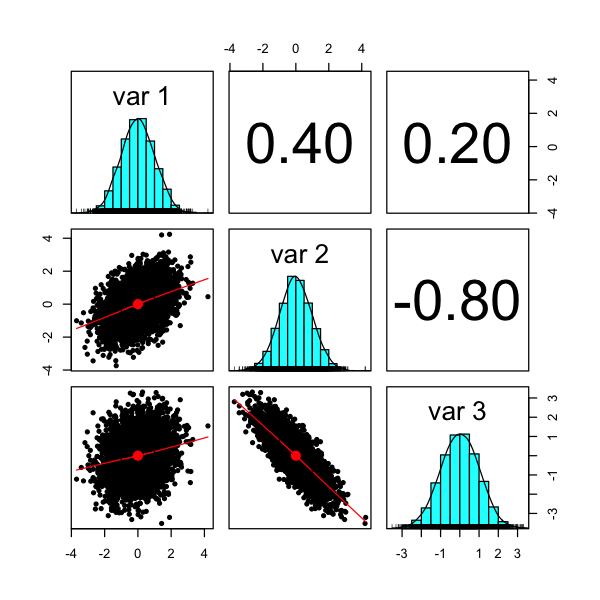

In [89]:
library(psych)
cor(z,method='spearman')
pairs.panels(z)

The output and the pairplot show us that indeed our samples have exactly the expected correlation structure.
Rplot

And now comes the magic trick: recall that if (X) is a random variable with distribution (F) then (F(X)) is uniformly distributed in the interval [0, 1]. In our toy example we already know the distribution (F) for each of the three random variables so this part is quick and straightforward.

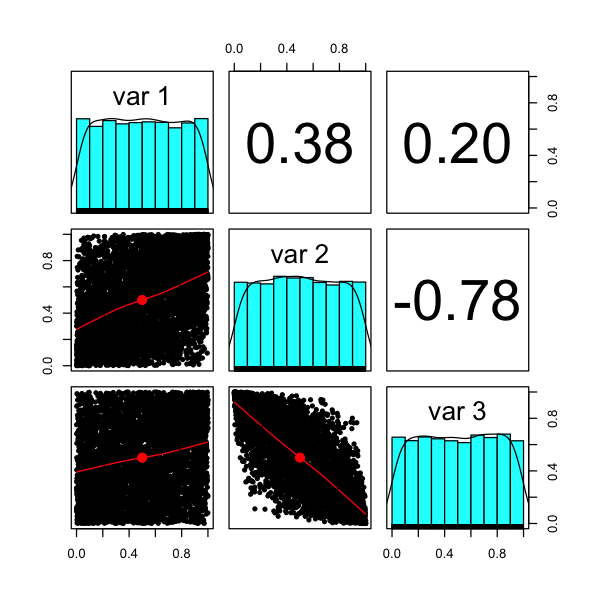

In [90]:
u <- pnorm(z)
pairs.panels(u)

Here is the pairplot of our new random variables contained in u. Note that each distribution is uniform in the [0,1] interval. Note also that the correlation the same, in fact, the transformation we applied did not change the correlation structure between the random variables. Basically we are left only with what is often referred as the dependence structure. Now, as a last step, we only need to select the marginals and apply them to u. I chose the marginals to be Gamma, Beta and Student distributed with the parameters specified below.

In [91]:
x1 <- qgamma(u[,1],shape=2,scale=1)
x2 <- qbeta(u[,2],2,2)
x3 <- qt(u[,3],df=5)

What is worth noticing is that by starting from a multivariate normal sample we have build a sample with the desired and fixed dependence structure and, basically, arbitrary marginals.



,x1,x2,x3
x1,1.0000000,0.3845236,0.1952917
x2,0.3845236,1.0000000,-0.7820997
x3,0.1952917,-0.7820997,1.0000000


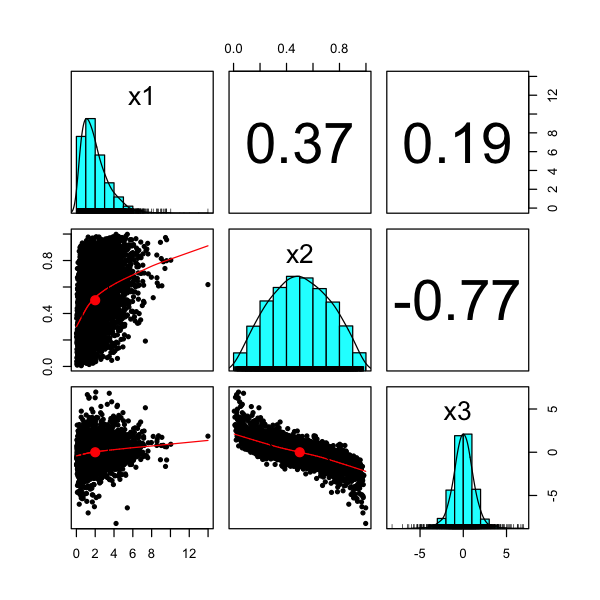

In [92]:
df <- cbind(x1,x2,x3)
pairs.panels(df)
cor(df,meth='spearman')

Again, I would like to emphasize that I chose totally arbitrary marginals. I could have chosen any marginal as long as it was a continuous function.

## Using the copula package

The whole process performed above can be done more efficiently, concisely and with some additional care entirely by the copula package. Let’s replicate the process above using copulas.

In [93]:
library(copula)
set.seed(100)
myCop <- normalCopula(param=c(0.4,0.2,-0.8), dim = 3, dispstr = "un")
myMvd <- mvdc(copula=myCop, margins=c("gamma", "beta", "t"),
              paramMargins=list(list(shape=2, scale=1),
                                list(shape1=2, shape2=2), 
                                list(df=5)) )

Now that we have specified the dependence structure through the copula (a normal copula) and set the marginals, the mvdc() function generates the desired distribution. Then we can generate random samples using the rmvdc() function.

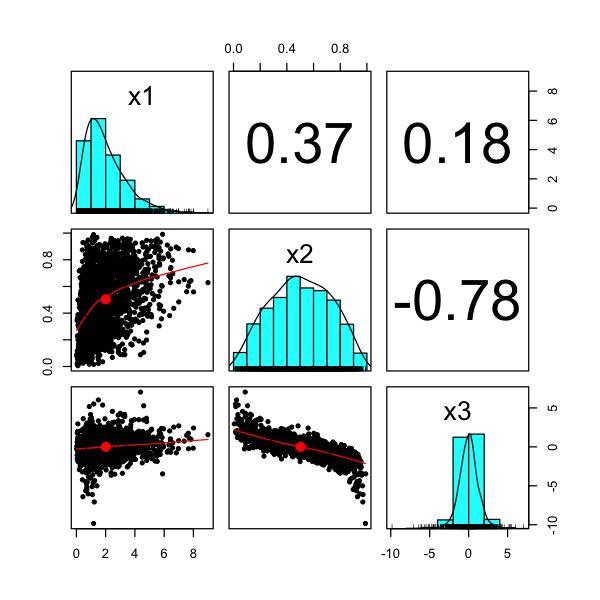

In [94]:
Z2 <- rMvdc(2000, myMvd)

colnames(Z2) <- c("x1", "x2", "x3")
pairs.panels(Z2)

## A simple example of application

Now for the real world example. We are going to fit a copula to the returns of two stocks and try to simulate the returns using the copula. I already cleaned the data from two stocks and calculated the returns, you can download the data in .csv format (yahoo, cree). Note that the data may not be exactly the one you can find on Google finance because I made some data cleaning and removed some outliers without much thinking mainly because this is a another toy example of application.
Let’s load the returns in R

In [95]:
cree <- read.csv('cree_r.csv',header=F)$V2
yahoo <- read.csv('yahoo_r.csv',header=F)$V2

Before going straight to the copula fitting process, let’s check the correlation between the two stock returns and plot the regression line:



[1] 0.4023584

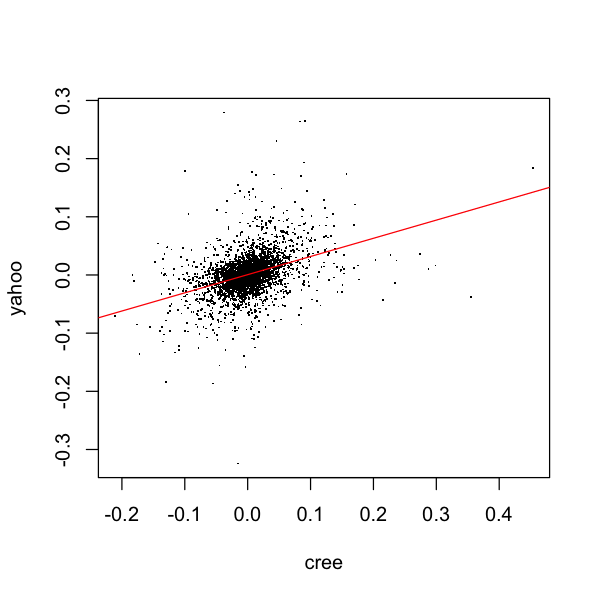

In [96]:
plot(cree,yahoo,pch='.')
abline(lm(yahoo~cree),col='red',lwd=1)
cor(cree,yahoo,method='spearman')

We can see a very mild positive correlation, the returns look mainly like a random blob on the plot.
In the first example above I chose a normal copula model without much thinking, however, when applying these models to real data one should carefully think at what could suit the data better. For instance, many copulas are better suited for modelling asymetrical correlation other emphasize tail correlation a lot, and so on. My guess for stock returns is that a t-copula should be fine, however a guess is certainly not enough. Fortunately, the VineCopula package offers a great function which tells us what copula we should use. Essentially the VineCopula library allows us to perform copula selection using BIC and AIC through the function BiCopSelect()

In [97]:
library(VineCopula)
u <- pobs(as.matrix(cbind(cree,yahoo)))[,1]
v <- pobs(as.matrix(cbind(cree,yahoo)))[,2]
selectedCopula <- BiCopSelect(u,v,familyset=NA)
selectedCopula

Bivariate copula: t (par = 0.44, par2 = 3.84, tau = 0.29) 

Note that I fed into the selection algorithm the pseudo observations using the pobs() function. Pseudo observations are the observations in the [0,1] interval.
The fitting algorithm indeed selected a t-copula (encoded as 2 in the $family reference) and estimated the parameters for us. By typing ?BiCopSelect() you can actually see the encoding for each copula.
Let’s try to fit the suggested model using the copula package and double check the parameters fitting.

In [98]:
t.cop <- tCopula(dim=2)
set.seed(500)
m <- pobs(as.matrix(cbind(cree,yahoo)))
fit <- fitCopula(t.cop,m,method='ml')
coef(fit)

rho.1       df 
0.435630 3.844527

It is nice to see that the parameters of the fitted copula are the same as those suggested by the BiCopSelect() function. Let’s take a look at the density of the copula we have just estimated

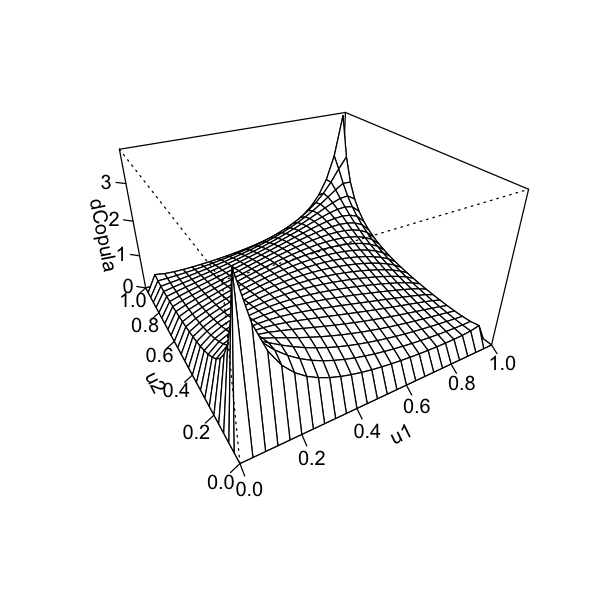

In [99]:
rho <- coef(fit)[1]
df <- coef(fit)[2]
persp(tCopula(dim=2,rho,df=df),dCopula)

Now we only need to build the copula and sample from it 5000 random samples.

1.0000000,0.3809354
0.3809354,1.0000000


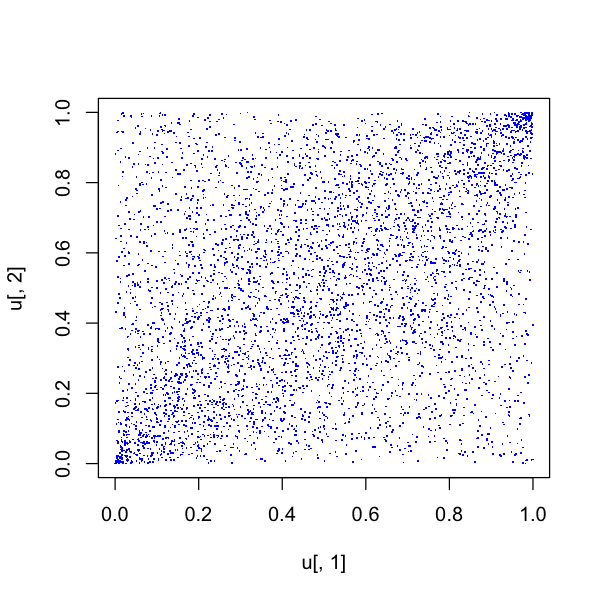

In [100]:
u <- rCopula(5000,tCopula(dim=2,rho,df=df))
plot(u[,1],u[,2],pch='.',col='blue')
cor(u,method='spearman')

This is the plot of the samples contained in the vector u. The random samples from the copula look a little bit close to the independence case, but that is fine since the correlation between the returns is low. Note that the generated samples have the same correlation as the data.
The t-copula emphasizes extreme results: it is usually good for modelling phenomena where there is high correlation in the extreme values (the tails of the distribution).
Note also that it is symmetrical, this might be an issue for our application, however we are going to neglect this.

Now we are facing the hard bit: modelling the marginals. We are going to assume normally distributed returns for simplicity even though it is well known to be a far from sound assumption. We therefore estimate the parameters of the marginals

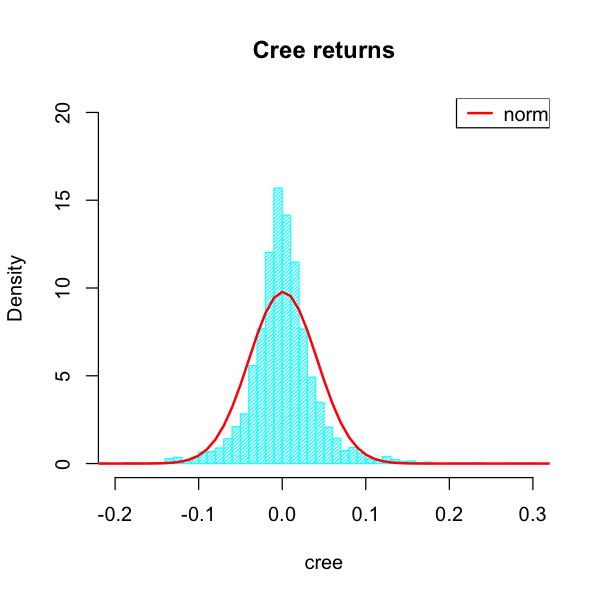

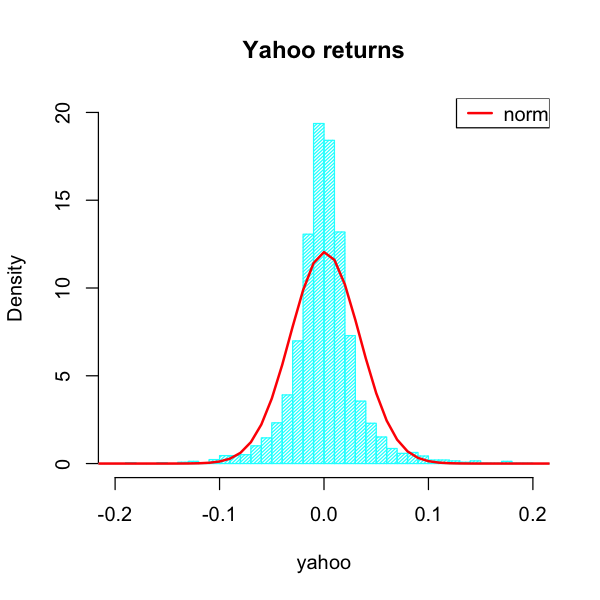

In [101]:
cree_mu <- mean(cree)
cree_sd <- sd(cree)
yahoo_mu <- mean(yahoo)
yahoo_sd <- sd(yahoo)

options(repr.plot.width=5, repr.plot.height=5)

hist(cree,breaks=80,main='Cree returns',freq=F,density=30,col='cyan',ylim=c(0,20),xlim=c(-0.2,0.3))
lines(seq(-0.5,0.5,0.01),dnorm(seq(-0.5,0.5,0.01),cree_mu,cree_sd),col='red',lwd=2)
legend('topright',c('normal'),col=c('red'),lwd=2)

hist(yahoo,breaks=80,main='Yahoo returns',density=30,col='cyan',freq=F,ylim=c(0,20),xlim=c(-0.2,0.2))
lines(seq(-0.5,0.5,0.01),dnorm(seq(-0.5,0.5,0.01),yahoo_mu,yahoo_sd),col='red',lwd=2)
legend('topright',c('normal'),col=c('red'),lwd=2)

Now we apply the copula in the mvdc() function and then use rmvdc() to get our simulated observations from the generated multivariate distribution. Finally, we compare the simulated results with the original data.

In [102]:
copula_dist <- mvdc(copula=tCopula(rho,dim=2,df=df), margins=c("norm","norm"),
                    paramMargins=list(list(mean=cree_mu, sd=cree_sd),
                                      list(mean=yahoo_mu, sd=yahoo_sd)))
sim <- rMvdc(5000,copula_dist)

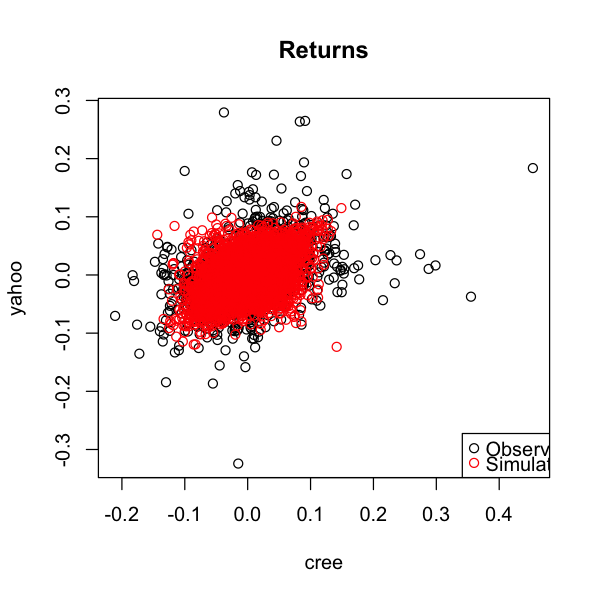

In [103]:
plot(cree,yahoo,main='Returns')
points(sim[,1],sim[,2],col='red')
legend('bottomright',c('Observed','Simulated'),col=c('black','red'),pch=21)

This is the final scatterplot of the data under the assumption of normal marginals and t-copula for the dependence structure:
As you can see, the t-copula leads to results close to the real observations, although there are fewer extreme returns than in the real data and we missed some of the most extreme result. If we were interested in modelling the risk associated with these stocks then this would be a major red flag to be addressed with further model calibration.

Since the purpose of this example is simply to show how to fit a copula and generate random observations using real data, we are going to stop here.

## Asymetric Copulas: The Gumbel Copula

Archimedean copulas are a particular class of copulas which can be built using a function phi known as the copula generator, from the following relation:

\begin{equation}
    C(u,v)=\phi^{[-1]}\Bigl( \phi(u) + \phi(v) \Bigr)
\end{equation}

In this chapter we are going to see the main formulas for using a particular Archimedean copula in R: the Gumbel copula. The gumbel copula is built using the generator function below

\begin{equation}
    \phi_\theta \,(t) = \bigl(- \ln \, t \bigr) ^\theta
\end{equation}

and has the following expression

\begin{equation}
    C(u,v) = \exp \Bigl[- \Bigl( \bigl(-\ln(u)\bigr)^\theta + \bigl(-\ln(v)\bigr)^\theta                       
    \Bigr)^{1/\theta} \Bigr], \quad \theta \in [1, \infty) 
\end{equation}

The package, available in R, which has some useful functions on the gumbel copula is called gumbel, you need to install it and then call it like this

In [104]:
library(gumbel)

Once you called it, here are some basic functions
here is the density function

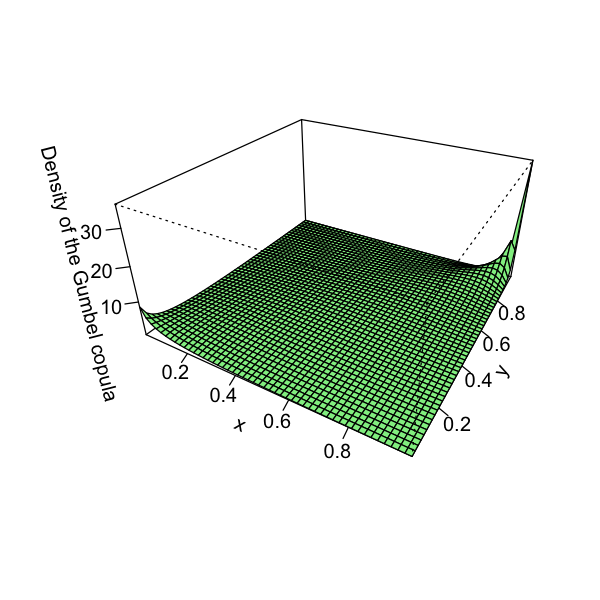

In [105]:
#plot the density
x <- seq(.01, .99, length = 50)
y <- x
z <- outer(x, y, dgumbel, alpha=2)
persp(x, y, z, theta = 30, phi = 30, expand = 0.5, col = "lightgreen", ltheta = 100,xlab = "x",
      ticktype = "detailed", ylab = "y", zlab = "Density of the Gumbel copula")

and the cumulative distribution function (CDF) 

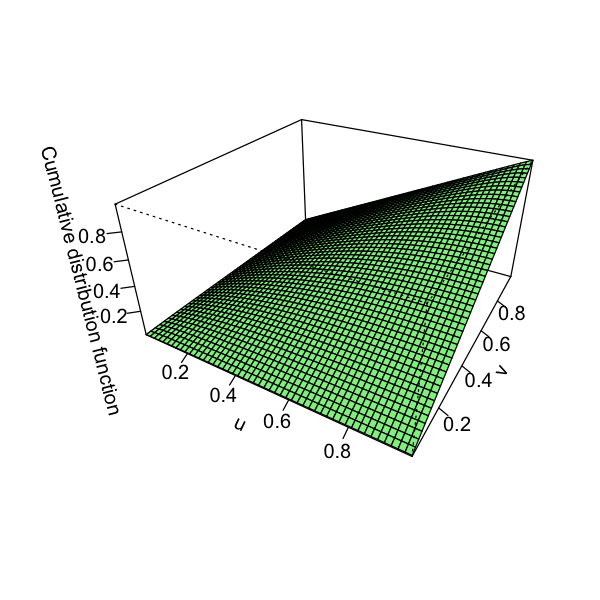

In [106]:
z <- outer(x, y, pgumbel, alpha=2)
persp(x, y, z, theta = 30, phi = 30, expand = 0.5, col = "lightgreen",ltheta = 100, 
      ticktype = "detailed",xlab = "u", ylab = "v", zlab = "Cumulative distribution function")

Finally, we are going to take a look at the random number generating function. The range of dependece simulated by the Gumbel copula, depends only on the parameter theta. As theta increases, so does the dependence between observations. As you may have noticed, if theta is equal to 1 (theta is in $[1,\infty)$ for the Gumbel copula), then we fall back in the independece case here below 


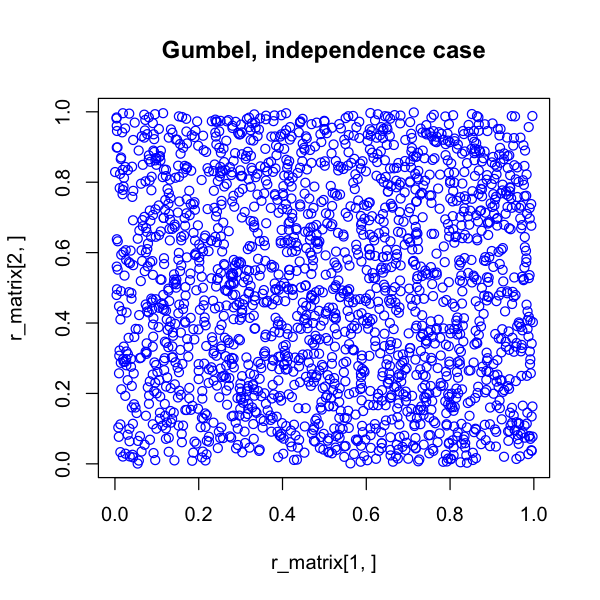

In [107]:
#we simulate 2000 observations with theta = 1
r_matrix <- t(rgumbel(2000,1))
plot(r_matrix[1,], r_matrix[2,], col="blue", main="Gumbel, independence case")

When we increase theta we obtain a different result, as expected 


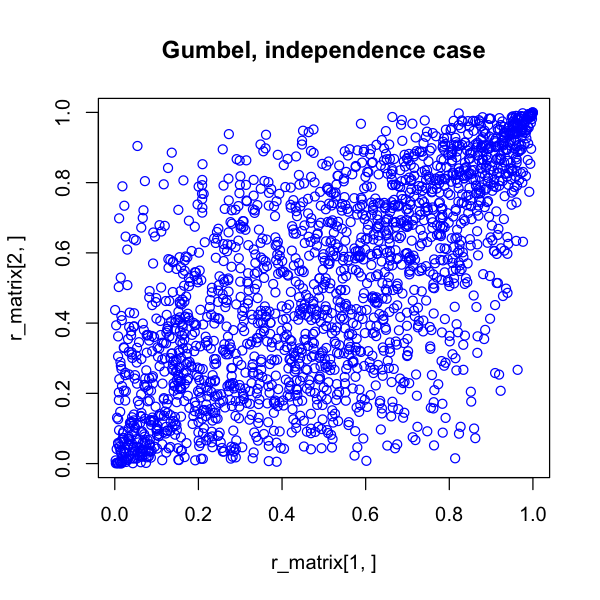

In [111]:
#we simulate 2000 observations with theta = 2
r_matrix <- t(rgumbel(2000,2))
plot(r_matrix[1,], r_matrix[2,], col="blue", main="Gumbel, independence case")

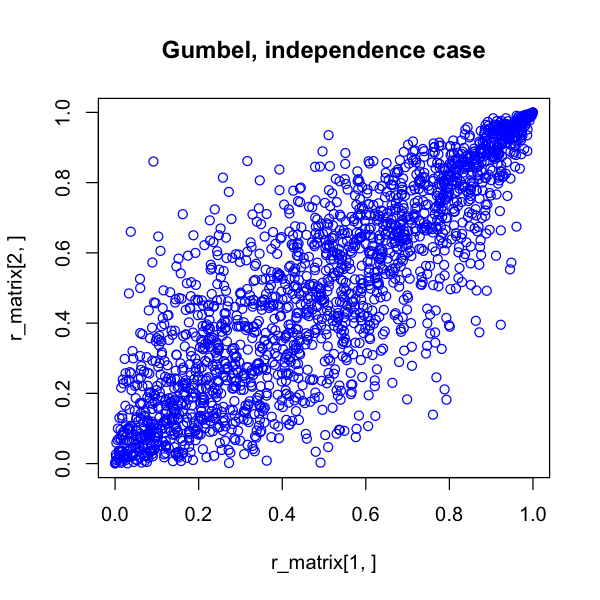

In [112]:
r_matrix <- t(rgumbel(2000,3))
plot(r_matrix[1,], r_matrix[2,], col="blue", main="Gumbel, independence case")

you can see that Gumbel copula can be used to simulate positive and asymetric dependence, in fact the correlation seems to be higher on larger values. 